# Q1: Predict the average rent of each state


- Phantira (Pearry) Khachichit
- Dai Ling Wu
- Han-Ju (Kylie) Hsieh

**Questions**

1.Use crime rate, homelessness, census data, historical average house selling prices to predict the rent of house in each state.

2.What are the most important variables when it comes to deciding the rent of a house?

**Prediction Variable**
- The rent of different types of house in each state.

**Links to raw datasets**
- Hosuing rent: https://www.kaggle.com/austinreese/usa-housing-listings
- Crime data: https://www.kaggle.com/mikejohnsonjr/united-states-crime-rates-by-county
- Historical House selling price: https://www.zillow.com/research/data/
- Census data: https://www.kaggle.com/muonneutrino/us-census-demographic-data?select=acs2017_county_data.csv
- Homelessness data: https://catalog.data.gov/dataset/homelessness-count-usa

**The cleaned data files are provided with notebooks**

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 


## Read in datasets

In [56]:
housing = pd.read_csv('cleaned_housing.csv')
historical_price = pd.read_csv('cleaned_historical_house_price.csv')
census_by_state = pd.read_csv('cleaned_censusbystate.csv')
homeless = pd.read_csv('cleaned_homelessness.csv')
crime_by_state = pd.read_csv('cleaned_crime_rate.csv')


In [ ]:
crime_by_state = crime_by_state.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

## Merge all datasets by state

In [58]:
merged = housing.merge(census_by_state,left_on='state',right_on='State').merge(
    crime_by_state, left_on=['State'], right_on = ['State'], how = 'inner').merge(
    homeless, left_on='State', right_on = 'state')

In [65]:
merged

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,...,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,crime_rate_per_100000,NumberofHomelessness
0,reno / tahoe,1148,apartment,1078,3,2.0,1,1,0,0,...,6.67,25.53,310239.91,71.15,18.88,9.57,0.41,8.27,416.077953,633097
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,0,0,...,6.67,25.53,310239.91,71.15,18.88,9.57,0.41,8.27,416.077953,633097
2,reno / tahoe,1095,apartment,708,1,1.0,1,1,1,0,...,6.67,25.53,310239.91,71.15,18.88,9.57,0.41,8.27,416.077953,633097
3,reno / tahoe,935,apartment,661,1,1.0,1,1,1,0,...,6.67,25.53,310239.91,71.15,18.88,9.57,0.41,8.27,416.077953,633097
4,reno / tahoe,1095,apartment,708,1,1.0,1,1,1,0,...,6.67,25.53,310239.91,71.15,18.88,9.57,0.41,8.27,416.077953,633097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169370,texarkana,629,apartment,805,2,1.5,1,1,1,0,...,3.25,23.01,17020.48,75.23,17.19,7.38,0.20,7.29,334.750727,14533
169371,texarkana,779,apartment,1125,3,2.0,1,1,1,0,...,3.25,23.01,17020.48,75.23,17.19,7.38,0.20,7.29,334.750727,14533
169372,texarkana,649,apartment,825,2,2.0,1,1,1,0,...,3.25,23.01,17020.48,75.23,17.19,7.38,0.20,7.29,334.750727,14533
169373,texarkana,569,apartment,612,1,1.0,1,1,1,0,...,3.25,23.01,17020.48,75.23,17.19,7.38,0.20,7.29,334.750727,14533


In [62]:
merged.drop(columns=['Unnamed: 0','id','state_x','state_y',],inplace=True)

# Correlation Matrix

<AxesSubplot:>

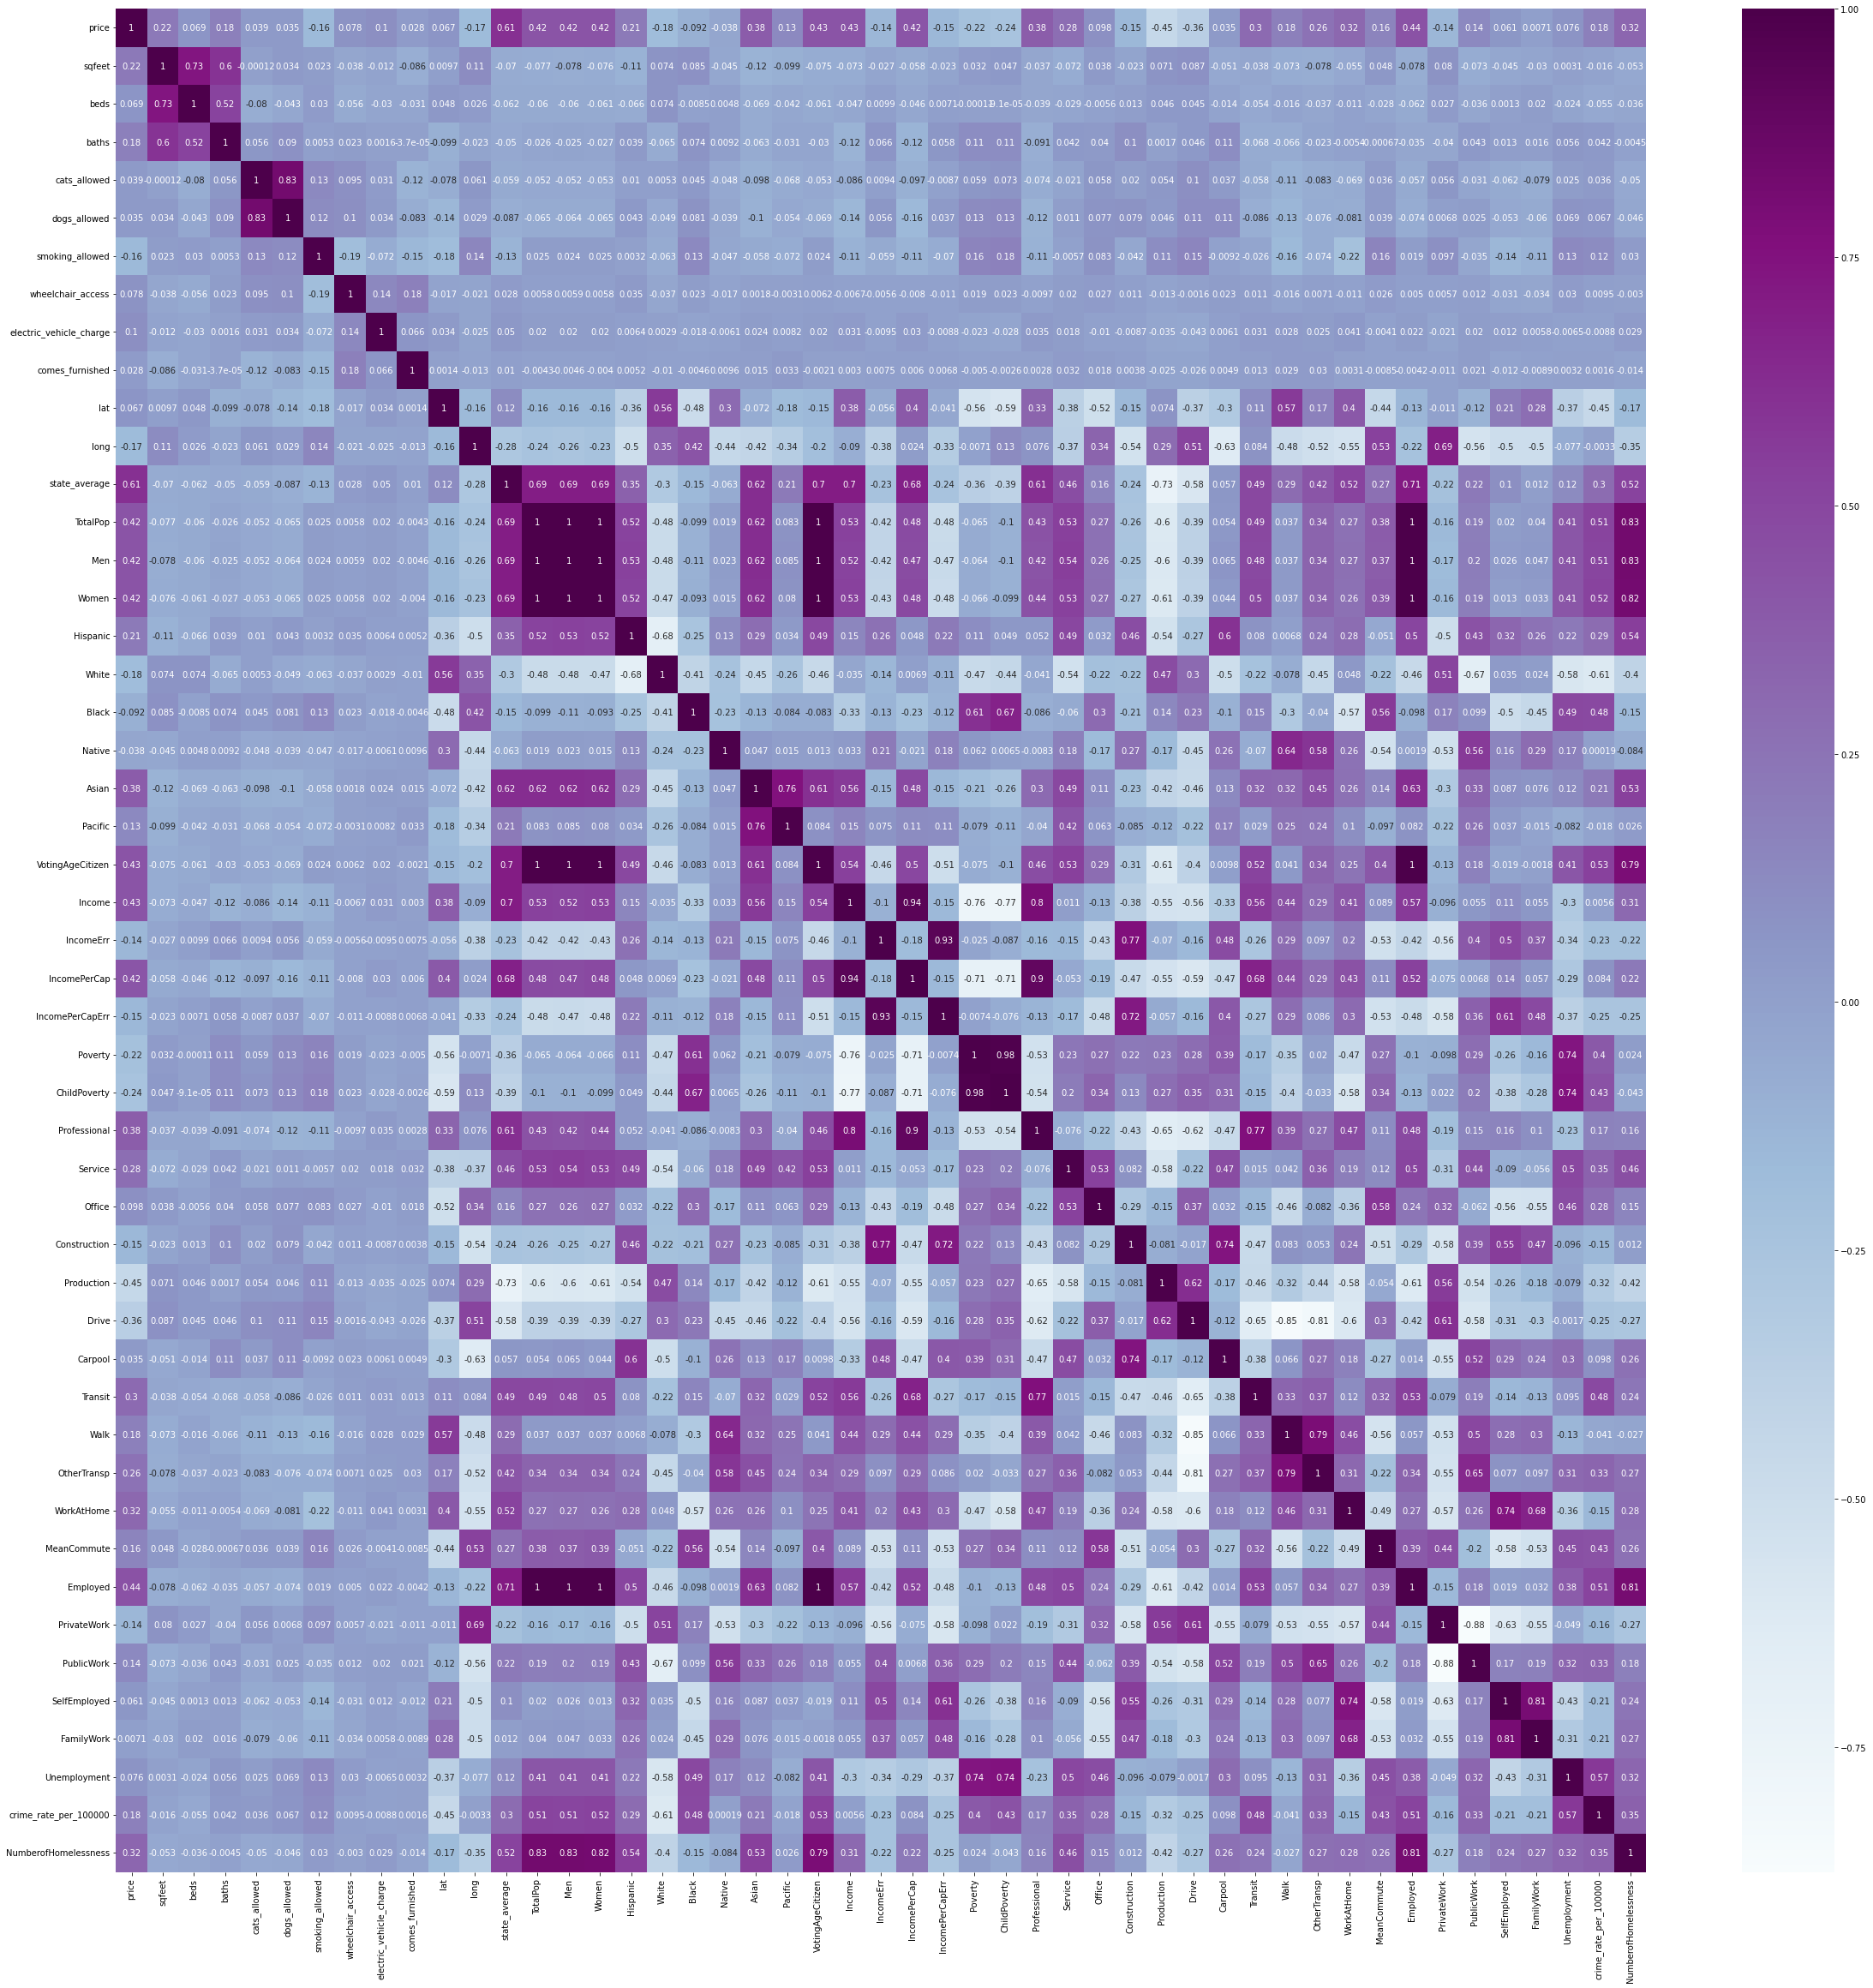

In [76]:
plt.figure(figsize=(40,40))
sns.heatmap(merged.corr(), annot=True, cmap='BuPu')

There are several variables which are highly correlated (correlation > 0.9) with others.
- `TotalPop`, `Men`, `Women`, `VotingAgeCitizen`, `Employed`
-  `Asain`, `Pacific`
- `Income`, `IncomePerCap`
- `IncomePerErr`, `IncomePerCapErr`
- `Poverty`, `ChildPoverty`
- `Walk`, `OtherTransp`


# Split train and test data

In [83]:
X = merged[['crime_rate_per_100000','NumberofHomelessness']]
y = merged['state_average']

X = X.drop_duplicates()
y = y.drop_duplicates()

In [67]:
from sklearn.model_selection import train_test_split

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

# Linear Regression

In [19]:
import statsmodels.formula.api as smf

In [85]:
reg_multi_price = smf.ols('state_average ~ NumberofHomelessness + crime_rate_per_100000',merged).fit()
reg_multi_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          state_average   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 3.432e+04
Date:                Sun, 28 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:02:04   Log-Likelihood:            -1.1087e+06
No. Observations:              169375   AIC:                         2.217e+06
Df Residuals:                  169372   BIC:                         2.217e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               928.1789      0.945    982.692      0.000     926.328     930.030
NumberofHomelessness      0.0006    2.6e-06    218.836      0.000       0.001       0.001
crime_rate_per_100000     0.1948      0.003     58.027      0.000       0.188       0.201
==============================================================================
Omnibus:                    22627.639   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33037.557
Skew:                           1.013   Prob(JB):                         0.00
Kurtosis:                       3.758   Cond. No.                     4.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

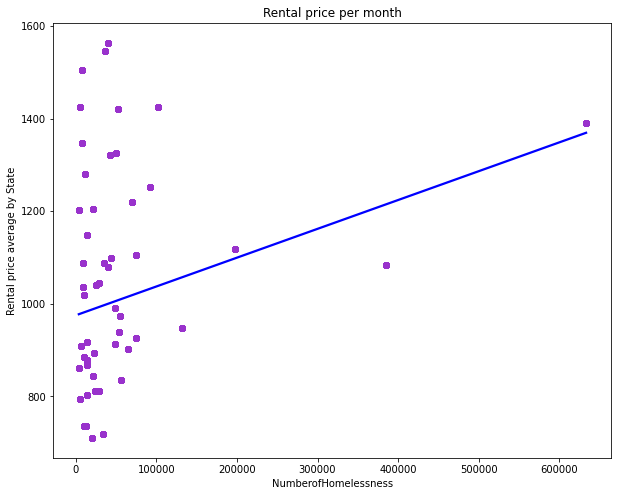

In [102]:
plt.figure(figsize=(10,8))
sns.regplot(x="NumberofHomelessness",y="state_average",data=merged, ci=None, order=1, 
            scatter_kws={"color": "darkorchid"}, 
            line_kws={"color": "blue"}).set(title='Rental price per month',
                                            xlabel='Number of Homelessness',
                                            ylabel = 'Rental price average by State',
                                            )
plt.show()


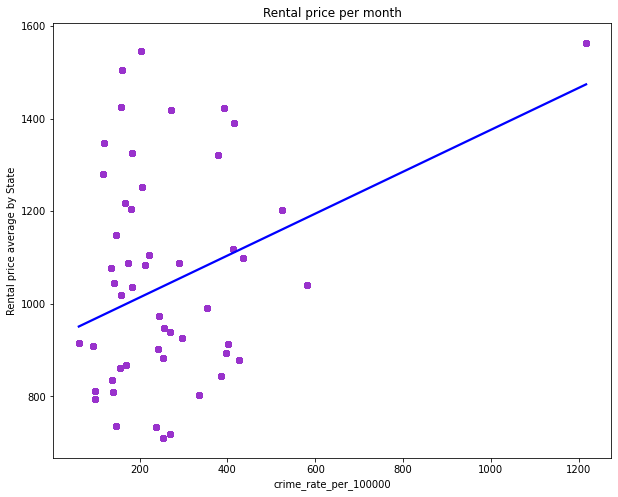

In [103]:
plt.figure(figsize=(10,8))
sns.regplot(x="crime_rate_per_100000",y="state_average",data=merged, ci=None, order=1, 
            scatter_kws={"color": "darkorchid"}, 
            line_kws={"color": "blue"}).set(title='Rental price per month',
                                            xlabel='crime_rate_per_100000',
                                            ylabel = 'Rental price average by State')
plt.show()

As you can see, the relationship between the Rental price average by State and the variables "Number of Homelessness" and "crime rate" are not linear regression. The performance of the model according to R-Square is not satisfied. As a result, we will perform Random Forest Regression to improve the performance of the models.

# Random Forest Regression

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)

print('R squared of RF:', RF_model.score(X_train,y_train))

R squared of RF: 0.8496256244010683


Compared to the R-Square of linear regression model, which is 0.288, the R-Square of Random Forest Regressor made a huge improvement. 

## REFERENCES

**List any references you used to complete your homework. Even if they are one of the books assigned for this class. If this section is incomplete you will be deducted 50% of your final grade from this homework.**
- Lab 2-3 / Homework 1-2 Jupyter notebook

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c62e4f61-5454-4e18-b0e0-542e6e7256b8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>